# Creation of dataframe for gravity model

This notebook combines the city data frame from notebook 03 and the co-occurrence data from notebook 01 into one dataframe. The combined dataframe is then used to calculate the distances between the cities as needed for the gravity model.

Add Dummies for Borders, Region and Language Sphere.

Furthermore LineString objects are created for the connection between each city (for mapping).

## Required Input
All required input is available within this repository

## Creates the following output
saved as a .csv at `../../output/edges.csv`  
saved as a shapefile at `../../output/maps/edges.shp`  

also versions without only the city links that appear in both corpuses  
saved as a .csv at `../../output/edges_nz.csv`   
saved as a shapefile at `../../output/maps/edges_nz.shp` 

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import re
from tqdm.notebook import tqdm
import unidecode
from collections import Counter
from shapely.geometry import Point, LineString, Polygon

## Functions

In [2]:
# creates a shapely line object between the two city points
def create_edge(row):
    edge = LineString([row['geometry_A'], row['geometry_B']])
    return edge

## Load Data

In [3]:
INDIR = "../../input"
OUTDIR = "../../output"
FILE_cities = "List_of_cities_300k.csv"
FILE_enpair = "citypairs_en.csv"
FILE_frpair = "citypairs_fr.csv"

In [4]:
# load the nodes dataset
fp = os.path.join(INDIR, "maps/nodes.shp")
gdf = gpd.read_file(fp)

# change projection CRS (needed for distance calculation later on)
gdf = gdf.to_crs('EPSG:3035')
gdf.crs

<Derived Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Turkey; United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.58, 24.6, 44.83, 84.73)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: Europ

<AxesSubplot:>

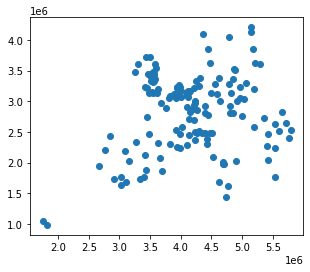

In [5]:
gdf.plot()

In [6]:
# load the pairs datasets
pairs_df_en = pd.read_csv(os.path.join(OUTDIR, FILE_enpair))
pairs_df_fr = pd.read_csv(os.path.join(OUTDIR, FILE_frpair))

## Edges

In [7]:
pairs_df_en.head()

,city_A,city_B,col_en
0,Paris,London,21874.0
1,Paris,Madrid,3394.0
2,Paris,Berlin,7899.0
3,Paris,Milan,3342.0
4,Paris,Barcelona,2397.0


In [8]:
# remove accents from names to enable join
gdf['MUA'] = [unidecode.unidecode(city) for city in gdf['MUA']]

In [9]:
# join on city_A
edges = pd.merge(pairs_df_en, gdf, how='left', left_on = 'city_A', right_on = 'MUA')

In [10]:
# join on city_B
edges = pd.merge(edges, gdf, how='left', left_on = 'city_B', right_on = 'MUA', suffixes=('_A', '_B'))

In [11]:
edges.head()

,city_A,city_B,col_en,MUA_A,POP_A,CC_A,WEST_A,SOUTH_A,NORTH_A,CEAST_A,...,POP_B,CC_B,WEST_B,SOUTH_B,NORTH_B,CEAST_B,REGION_B,EN_DUM_B,FR_DUM_B,geometry_B
0,Paris,London,21874.0,Paris,9591,FR,1,0,0,0,...,8256,UK,1,0,0,0,west,1,0,POINT (3623219.566 3204183.954)
1,Paris,Madrid,3394.0,Paris,9591,FR,1,0,0,0,...,4955,ES,0,1,0,0,south,0,0,POINT (3161798.324 2030549.871)
2,Paris,Berlin,7899.0,Paris,9591,FR,1,0,0,0,...,3776,DE,1,0,0,0,west,0,0,POINT (4552085.153 3273010.955)
3,Paris,Milan,3342.0,Paris,9591,FR,1,0,0,0,...,3698,IT,0,1,0,0,south,0,0,POINT (4256391.191 2484870.286)
4,Paris,Barcelona,2397.0,Paris,9591,FR,1,0,0,0,...,3659,ES,0,1,0,0,south,0,0,POINT (3664331.118 2067683.425)


In [12]:
# add the french collocations
edges['col_fr'] = pairs_df_fr['col_fr'].copy()

### Create LineString Edges

In [13]:
edges.head()

,city_A,city_B,col_en,MUA_A,POP_A,CC_A,WEST_A,SOUTH_A,NORTH_A,CEAST_A,...,CC_B,WEST_B,SOUTH_B,NORTH_B,CEAST_B,REGION_B,EN_DUM_B,FR_DUM_B,geometry_B,col_fr
0,Paris,London,21874.0,Paris,9591,FR,1,0,0,0,...,UK,1,0,0,0,west,1,0,POINT (3623219.566 3204183.954),10733.0
1,Paris,Madrid,3394.0,Paris,9591,FR,1,0,0,0,...,ES,0,1,0,0,south,0,0,POINT (3161798.324 2030549.871),2404.0
2,Paris,Berlin,7899.0,Paris,9591,FR,1,0,0,0,...,DE,1,0,0,0,west,0,0,POINT (4552085.153 3273010.955),4723.0
3,Paris,Milan,3342.0,Paris,9591,FR,1,0,0,0,...,IT,0,1,0,0,south,0,0,POINT (4256391.191 2484870.286),2713.0
4,Paris,Barcelona,2397.0,Paris,9591,FR,1,0,0,0,...,ES,0,1,0,0,south,0,0,POINT (3664331.118 2067683.425),1696.0


In [14]:
# add LineString objects
edges['geometry'] = edges.apply(create_edge, axis = 1)

/Users/brecht/opt/anaconda3/envs/citynet/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [15]:
edges.head()

,city_A,city_B,col_en,MUA_A,POP_A,CC_A,WEST_A,SOUTH_A,NORTH_A,CEAST_A,...,WEST_B,SOUTH_B,NORTH_B,CEAST_B,REGION_B,EN_DUM_B,FR_DUM_B,geometry_B,col_fr,geometry
0,Paris,London,21874.0,Paris,9591,FR,1,0,0,0,...,1,0,0,0,west,1,0,POINT (3623219.566 3204183.954),10733.0,LINESTRING (3760015.3675289643 2889948.6954368...
1,Paris,Madrid,3394.0,Paris,9591,FR,1,0,0,0,...,0,1,0,0,south,0,0,POINT (3161798.324 2030549.871),2404.0,LINESTRING (3760015.3675289643 2889948.6954368...
2,Paris,Berlin,7899.0,Paris,9591,FR,1,0,0,0,...,1,0,0,0,west,0,0,POINT (4552085.153 3273010.955),4723.0,LINESTRING (3760015.3675289643 2889948.6954368...
3,Paris,Milan,3342.0,Paris,9591,FR,1,0,0,0,...,0,1,0,0,south,0,0,POINT (4256391.191 2484870.286),2713.0,LINESTRING (3760015.3675289643 2889948.6954368...
4,Paris,Barcelona,2397.0,Paris,9591,FR,1,0,0,0,...,0,1,0,0,south,0,0,POINT (3664331.118 2067683.425),1696.0,LINESTRING (3760015.3675289643 2889948.6954368...


### Distances

In [16]:
# add column with the distances
edges['distance'] = [edge.length/1000 for edge in edges.geometry]

### Dummies


In [17]:
## BORDER DUMMIES

# border dummy (1 if the two cities are in different spheres)
edges['border_DUM'] = np.where(edges['CC_A'] != edges['CC_B'], 1, 0)

# regional border
edges['reg_border'] = np.where(edges['REGION_A'] != edges['REGION_B'], 1, 0)

## REGION DUMMIES

edges['CEAST'] = np.where((edges['REGION_A'] == 'central_east') | (edges['REGION_B'] == 'central_east'), 1, 0)
edges['SOUTH'] = np.where((edges['REGION_A'] == 'south') | (edges['REGION_B'] == 'south'), 1, 0)
edges['WEST'] = np.where((edges['REGION_A'] == 'west') | (edges['REGION_B'] == 'west'), 1, 0)
edges['NORTH'] = np.where((edges['REGION_A'] == 'north') | (edges['REGION_B'] == 'north'), 1, 0)

## LANGUAGE SPHERE DUMMIES

# French sphere Dummy
edges['FR_con'] = np.where((edges['FR_DUM_A'] == 1) | (edges['FR_DUM_B'] == 1), 1, 0)

# inside french sphere completely is 1 if both cities in the french sphere
edges['FR_int'] = np.where((edges['FR_DUM_A'] == 1) & (edges['FR_DUM_B'] == 1), 1, 0)

# English sphere Dummy
edges['EN_con'] = np.where((edges['EN_DUM_A'] == 1) | (edges['EN_DUM_B'] == 1), 1, 0)

# is 1 if both cities in the english sphere
edges['EN_int'] = np.where((edges['EN_DUM_A'] == 1) & (edges['EN_DUM_B'] == 1), 1, 0)


In [18]:
# adjust order of columns and drop the dummies for nodes
edges = edges[['city_A', 'city_B', 'POP_A', 'POP_B', 'CC_A', 'CC_B','distance', 'border_DUM', 'reg_border', 
         'FR_con', 'FR_int', 'EN_con', 'EN_int', 'CEAST', 'SOUTH', 'WEST', 'NORTH',
         'col_en', 'col_fr', 'geometry']].copy()

In [19]:
edges.shape

(11325, 20)

## adjust co-occurrences
Use paragraph count from notebook 02 to calculate a comparable version of french and english co-occurrences

In [20]:
# fr paragraph count = 6005355
# en paragraph count = 10436996
# see count paragraph notebook
fr_count = 6005355
en_count = 10436996

edges['col_prop_fr'] = [(collocation / fr_count)*1000 for collocation in edges['col_fr']]
edges['col_prop_en'] = [(collocation / en_count)*1000 for collocation in edges['col_en']]

In [21]:
edges[['city_A', 'city_B', 'col_prop_fr', 'col_prop_en']].head()

,city_A,city_B,col_prop_fr,col_prop_en
0,Paris,London,1.787238,2.095814
1,Paris,Madrid,0.400309,0.325189
2,Paris,Berlin,0.786465,0.756827
3,Paris,Milan,0.451763,0.320207
4,Paris,Barcelona,0.282415,0.229664


### Saving the output
saved as a .csv at `../../output/edges.csv`  
saved as a shapefile at `../../output/edges.shp`  

also versions without only the city links that appear in both corpuses  
saved as a .csv at `../../output/edges_nz.csv`   
saved as a shapefile at `../../output/edges_nz.shp`  

In [22]:
# transform into a geodataframe
edge_gdf = gpd.GeoDataFrame(edges, columns = edges.columns, geometry = 'geometry', crs = gdf.crs)

# save as .shp for mapping
fp = os.path.join(OUTDIR, "maps/edges.shp")
edge_gdf.to_file(fp)

/Users/brecht/opt/anaconda3/envs/citynet/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/var/folders/15/8v892gvj639_bp8s5ftm80400000gn/T/ipykernel_13538/119097748.py:6: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  edge_gdf.to_file(fp)


<AxesSubplot:>

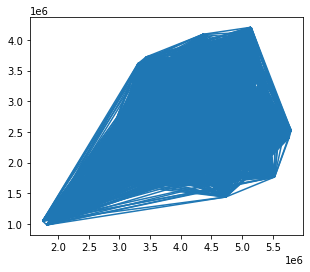

In [23]:
edge_gdf.plot()

In [24]:
# drop geometry column from df
edges.drop(['geometry'], axis = 1, inplace=True)

# # save as csv for gravity model
# file_name = "edges.csv"
# fp = os.path.join(OUTDIR, file_name)
# edges.to_csv(fp, index = False, sep = ";")

### Save a no-zeroes version

In [25]:
# subset so collocations are all larger than 0
nz_edge_df = edge_gdf[(edge_gdf.col_en > 0 ) & (edge_gdf.col_fr > 0)].copy()

In [26]:
# save the edges map
fp = os.path.join(OUTDIR, "maps/edges_nz.shp")
nz_edge_df.to_file(fp)

# and as csv
nz_edge_df.drop(['geometry'], axis = 1, inplace=True)

# save
fp = os.path.join(OUTDIR, "edges_nz.csv")
nz_edge_df.to_csv(fp, sep = ";", index = False)

/Users/brecht/opt/anaconda3/envs/citynet/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/var/folders/15/8v892gvj639_bp8s5ftm80400000gn/T/ipykernel_13538/2064704536.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nz_edge_df.to_file(fp)
